![Colegio Bourbaki](./Images/Bourbaki.png)

## Procesamiento de Lenguaje Natural

### Resumenes de texto utilizando RNN

Las opiniones de los clientes suelen ser largas y descriptivas. Analizar estas opiniones manualmente, como pueden imaginar, lleva mucho tiempo. Aquí es donde se puede aplicar Procesamiento del Lenguaje Natural para generar un resumen de las reseñas largas.

Trabajaremos de nuevo con el conjunto de Amazon usando el modelo GPT-2.

In [1]:
#Data Analysis
import numpy as np
import pandas as pd

#Text preprocessing
import matplotlib.pyplot as plt
import re
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Data Loading
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Utils
import os
import sys
from sklearn.model_selection import train_test_split
#from torchsummary import summary
from tqdm.notebook import tqdm  # Display progress bar

## Configuraciones

In [2]:
# Set seed for random generators
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
torch.cuda.empty_cache()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda:0'

In [6]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__, end="\n\n")

if torch.cuda.is_available():
    #print("__CUDA VERSION")
    #! nvcc --version
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__Devices:")
    print("Active CUDA Device: GPU", torch.cuda.current_device())
    print("Available devices ", torch.cuda.device_count())
    print("Current cuda device ", torch.cuda.current_device())
    #! nvidia-smi

__Python VERSION: 3.11.7 (main, Dec 29 2023, 12:40:11) [GCC 11.4.0]
__pyTorch VERSION: 2.1.2+cu121

__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__Devices:
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [7]:
pd.set_option("display.max_colwidth", 200)

### Carga de Datos

Este conjunto de datos está formado por reseñas de alimentos selectos de Amazon. Los datos abarcan un periodo de más de 10 años e incluyen todas las ~500.000 reseñas hasta octubre de 2012. Estas reseñas incluyen información sobre el producto y el usuario, valoraciones, reseñas en texto sin formato y resúmenes. También incluye reseñas de todas las demás categorías de Amazon.

Tomaremos una muestra de 100.000 reseñas para reducir el tiempo de entrenamiento de nuestro modelo. No dudes en utilizar el conjunto de datos completo para entrenar tu modelo si tu máquina dispone de esa potencia de cálculo.

In [8]:
data = pd.read_csv("./Data/Reviews.csv", low_memory=False)

In [9]:
data = data.sample(n=100, random_state=42) 

In [10]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,"Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch. They're crunchy and true to the texture of the other ""real"" cookies that aren't gluten-free..."
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,"My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts out of wherever she was hiding to come get a treat. She doesn't like crunchy treats much, so thes..."
427827,427828,B008FHUFAU,AOXC0JQQZGGB6,Kenneth Shevlin,0,2,3,1224028800,COFFEE TASTE,A little less than I expected. It tends to have a muddy taste - not what I expected since they said it was the favorite of the company.
433954,433955,B006BXV14E,A3PWPNZVMNX3PA,rareoopdvds,0,1,2,1335312000,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in original size, then there was Frosted Mini-Wheats Bite Size. Well, if for some reason those were too much of a mouthful, we now have Frosted Mini-Wheats Lit..."
70260,70261,B007I7Z3Z0,A1XNZ7PCE45KK7,Og8ys1,0,2,5,1334707200,Great Taste . . .,"and I want to congratulate the graphic artist for putting the entire product name on such a small box. The ad men must have really thought long and hard.<br /><br />But seriously, I love the prod..."


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 165256 to 398714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      100 non-null    int64 
 1   ProductId               100 non-null    object
 2   UserId                  100 non-null    object
 3   ProfileName             100 non-null    object
 4   HelpfulnessNumerator    100 non-null    int64 
 5   HelpfulnessDenominator  100 non-null    int64 
 6   Score                   100 non-null    int64 
 7   Time                    100 non-null    int64 
 8   Summary                 100 non-null    object
 9   Text                    100 non-null    object
dtypes: int64(5), object(5)
memory usage: 8.6+ KB


Vamos a desprendernos de las reseñas nulas y de las mismas que se repitan

In [12]:
data.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [13]:
# Drop Duplicates
data.drop_duplicates(subset=["Text"], inplace=True)
data = data.dropna()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 165256 to 398714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      100 non-null    int64 
 1   ProductId               100 non-null    object
 2   UserId                  100 non-null    object
 3   ProfileName             100 non-null    object
 4   HelpfulnessNumerator    100 non-null    int64 
 5   HelpfulnessDenominator  100 non-null    int64 
 6   Score                   100 non-null    int64 
 7   Time                    100 non-null    int64 
 8   Summary                 100 non-null    object
 9   Text                    100 non-null    object
dtypes: int64(5), object(5)
memory usage: 8.6+ KB


In [15]:
df = pd.DataFrame(data, columns=["Summary", "Text"])

In [16]:
del data

In [17]:
df.head()

,Summary,Text
165256,Crunchy & Good Gluten-Free Sandwich Cookies!,"Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bunch. They're crunchy and true to the texture of the other ""real"" cookies that aren't gluten-free..."
231465,great kitty treats,"My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts out of wherever she was hiding to come get a treat. She doesn't like crunchy treats much, so thes..."
427827,COFFEE TASTE,A little less than I expected. It tends to have a muddy taste - not what I expected since they said it was the favorite of the company.
433954,So the Mini-Wheats were too big?,"First there was Frosted Mini-Wheats, in original size, then there was Frosted Mini-Wheats Bite Size. Well, if for some reason those were too much of a mouthful, we now have Frosted Mini-Wheats Lit..."
70260,Great Taste . . .,"and I want to congratulate the graphic artist for putting the entire product name on such a small box. The ad men must have really thought long and hard.<br /><br />But seriously, I love the prod..."


### Preprocesamiento

Es muy importante realizar unos pasos básicos de preprocesamiento antes de pasar a la parte de construcción del modelo. Utilizar datos de texto desordenados y sin limpiar es un paso potencialmente desastroso. En este paso, eliminaremos del texto todos los símbolos, caracteres, etc. no deseados que no afecten al objetivo de nuestro problema.

Realizaremos las siguientes tareas de preprocesamiento de nuestros datos:

* Convertir todo a minúsculas
* Eliminar las etiquetas HTML
* Mapear Contracciones
* Eliminar ('s)
* Eliminar cualquier texto dentro del paréntesis ( )
* Eliminar puntuaciones y caracteres especiales
* Eliminar palabras vacías
* Eliminar palabras cortas

#### Preprocesar texto

In [18]:
stop_words = set(stopwords.words("english"))
html_tags_pattern = re.compile(r'<.*?>')

In [19]:
def text_cleaner(text):
    """
    Clean text column in the dataset.
    """
    # Remove HTML tags
    new_string =  re.sub(html_tags_pattern, '', text)
    # Remove quotes
    new_string = re.sub(r'"', "", new_string)
    # Expand contractions using the dictionary
    new_string = contractions.fix(new_string)
    # Remove possessive 's
    new_string = re.sub(r"'s\b", "", new_string)
    # Lowercase words
    new_string = new_string.lower()
    # Remove non-alphabetic characters and short words, filter stop words
    tokens = [
        w
        for w in re.findall(r"\b\w+\b", new_string)
        if len(w) >= 3 and w not in stop_words
    ]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join long words
    cleaned_text = " ".join(tokens).strip()
    
    return cleaned_text

b) Summary Cleaning

In [20]:
def summary_cleaner(text):
    """
    Clean summary column in dataset
    """
    # Remove quotes
    new_string = re.sub('"', "", str(text))
    # Expand contractions using the dictionary
    new_string = contractions.fix(new_string)
    # Remove possessive 's
    new_string = re.sub(r"'s\b", "", new_string)
    # Match all strings that contain a non-letter
    new_string = re.sub("[^a-zA-Z]", " ", new_string)
    # Lowercase words
    new_string = new_string.lower()
    # Tokenization
    tokens = new_string.split()
    # Remove shortwords
    #new_string = " ".join([i for i in tokens if len(i) > 1])
    new_string = " ".join([i for i in tokens])
    
    return new_string

In [21]:
%%time
df["Text"] = df["Text"].apply(text_cleaner)
df["Summary"] = df["Summary"].apply(summary_cleaner)
# Lo hacemos in-place

CPU times: user 1.13 s, sys: 10.8 ms, total: 1.14 s
Wall time: 1.15 s


In [22]:
df.head()

,Summary,Text
165256,crunchy good gluten free sandwich cookies,tried couple brand gluten free sandwich cooky best bunch crunchy true texture real cooky gluten free might think filling make bit sweet mean satisfied sweet tooth sooner chocolate version glutino ...
231465,great kitty treats,cat love treat ever cannot find house pop top bolt wherever hiding come get treat like crunchy treat much perfect given three flavor seems like equally tend dry time near end bottle however flip t...
427827,coffee taste,little le expected tends muddy taste expected since said favorite company
433954,so the mini wheats were too big,first frosted mini wheat original size frosted mini wheat bite size well reason much mouthful frosted mini wheat little bit yes half size bite size version particular one cinnamon roll nothing new...
70260,great taste,want congratulate graphic artist putting entire product name small box men must really thought long hard seriously love product taste refreshing thought taste pleasing aftertaste sweet goldilocks ...


### Distribución de las secuencias
Aquí analizaremos la longitud de las reseñas y del resumen para hacernos una idea general de la distribución de la longitud del texto. 

Esto nos ayudará a fijar la longitud máxima de la secuencia

In [23]:
review_words = df["Text"].apply(lambda x: len(str(x).split()))

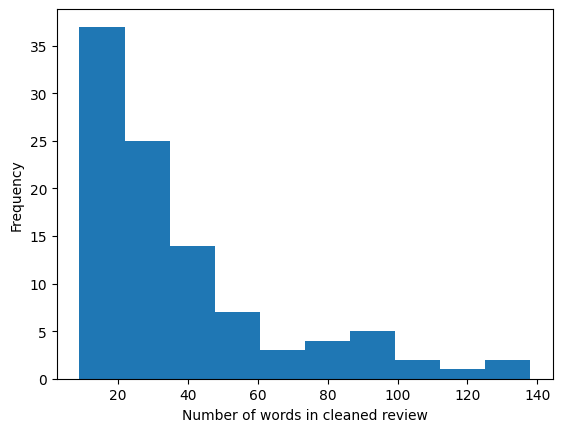

In [24]:
review_words.plot.hist(bins=10)
plt.xlabel("Number of words in cleaned review")
plt.show()

In [25]:
review_words.describe()

count    100.000000
mean      36.960000
std       29.369785
min        9.000000
25%       16.000000
50%       26.500000
75%       46.000000
max      138.000000
Name: Text, dtype: float64

In [26]:
p=0.9
print(f"El {100*p:.0f}% de las reseñas tiene {review_words.quantile(p):.0f} palabras")

El 90% de las reseñas tiene 86 palabras


In [27]:
all_text = ' '.join(df['Text'])
rev_unique_words = set(all_text.split())
rev_unique_words = len(rev_unique_words)
print(f"La serie Reseñas tiene {rev_unique_words} palabras únicas")

La serie Reseñas tiene 1415 palabras únicas


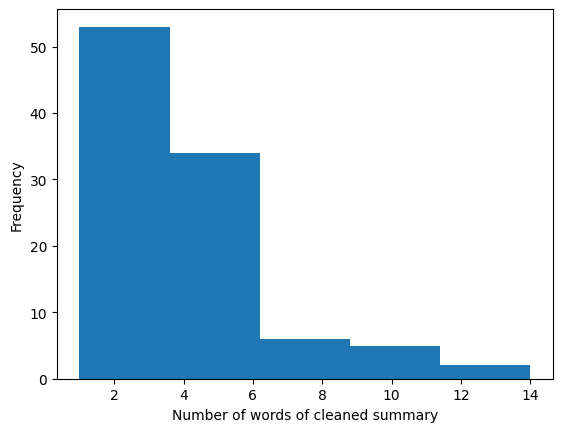

In [28]:
summary_words = df["Summary"].apply(lambda x: len(str(x).split()))
summary_words.plot.hist(bins=5)
plt.xlabel("Number of words of cleaned summary")
plt.show()

In [29]:
summary_words.describe()

count    100.000000
mean       4.000000
std        2.506557
min        1.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       14.000000
Name: Summary, dtype: float64

In [30]:
print(f"El {100*p:.0f}% de los Resúmenes tiene {summary_words.quantile(p):.0f} palabras")

El 90% de los Resúmenes tiene 7 palabras


In [31]:
all_text = ' '.join(df['Summary'])
sum_unique_words = set(all_text.split())
sum_unique_words = len(sum_unique_words)
print(f"La serie Resumen tiene {sum_unique_words} palabras únicas")

La serie Resumen tiene 242 palabras únicas


In [32]:
max_len_text = int(review_words.quantile(p))
max_len_summary = int(summary_words.quantile(p))
max_len_text, max_len_summary

(86, 7)

Nos estamos acercando a la parte de construcción del modelo. Antes de eso, tenemos que dividir nuestro conjunto de datos en un conjunto de entrenamiento y otro de validación. Utilizaremos el 80% del conjunto de datos como datos de entrenamiento y evaluaremos el rendimiento con el 20% restante

In [33]:
x_train, x_test, y_train, y_test = train_test_split(
    df["Text"], df["Summary"], test_size=0.2, random_state=42, shuffle=True
)

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [35]:
print(
    f"Hay {len(x_train)} reseñas en el conjunto de entrenamiento, {len(x_val)} en validación y {len(x_test)} reseñas en el conjunto de prueba"
)

Hay 72 reseñas en el conjunto de entrenamiento, 8 en validación y 20 reseñas en el conjunto de prueba


### Tokenización

In [36]:
model_name = 'gpt2'

In [37]:
tokenizer = GPT2Tokenizer.from_pretrained(
    model_name,
)

tokenizer.pad_token = tokenizer.eos_token

In [38]:
class SummaryDataset(Dataset):
    def __init__(self, input_texts, target_texts, tokenizer, max_length):
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.tokenizer = tokenizer
        self.max_length = max_length
 
    def __len__(self):
        return len(self.input_texts)
    
    def __getitem__(self, idx):
        input_text = self.input_texts[idx]
        target_text = self.target_texts[idx]
        
        # Encode the concatenated input text
        input_encoded = self.tokenizer(input_text, max_length=self.max_length, padding='max_length', return_tensors="pt")
        
        # Encode the target text
        target_encoded = self.tokenizer(target_text, max_length=self.max_length, padding='max_length', return_tensors="pt")

        input_ids = input_encoded['input_ids'].squeeze()
        target_ids = target_encoded['input_ids'].squeeze()
        return {"input_ids": input_ids, "labels": target_ids}

In [39]:
#Hiperparámetros
EPOCHS = 20
BATCH_SIZE = 2
LR = 0.0001
max_length = max_len_text 

In [40]:
def custom_collate(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    # Pad input_ids and labels to have the same length within a batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    input_ids_padded = input_ids_padded[:, :max_length]
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels_padded = labels_padded[:, :max_length] 
    
    return {'input_ids': input_ids_padded, 'labels': labels_padded}

In [41]:
dataset_train = SummaryDataset(x_train.to_list(), y_train.to_list(), tokenizer, max_length=max_length)

In [42]:
#train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)

In [48]:
train_loader.dataset[0]

{'input_ids': tensor([   70,  1809,  1972, 27644,  5858,   390,   457,  3650, 18550,  3753,
          6481,  1327,  1064,  6149,  7725,   561,  3223, 11311,  4336,  3223,
         11311,   772,  6938,  1310,  1468, 39985, 38973, 12591,  6029,  2938,
          2035, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256]),
 'labels': tensor([ 1662,   262, 27644, 13917,  1312,  6348,   510,   351])}

### Modelo GPT2

In [44]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, amsgrad=True, weight_decay=LR*0.1)

In [45]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [46]:
model.train()
loss_train = []
total_loss_train = []

for epoch in range(EPOCHS):
    for batch_idx, batch in tqdm(
            enumerate(train_loader), desc="Epoch_Train", total=len(train_loader)
        ):
        input = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input, labels=labels)
        loss = outputs.loss
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.item())
        
    print(f"Epoch: {epoch}, Loss: {sum(loss_train) / len(loss_train)}")
    total_loss_train.append(sum(loss_train) / len(loss_train))

Epoch_Train:   0%|          | 0/36 [00:00<?, ?it/s]

ValueError: Expected input batch_size (170) to match target batch_size (12).

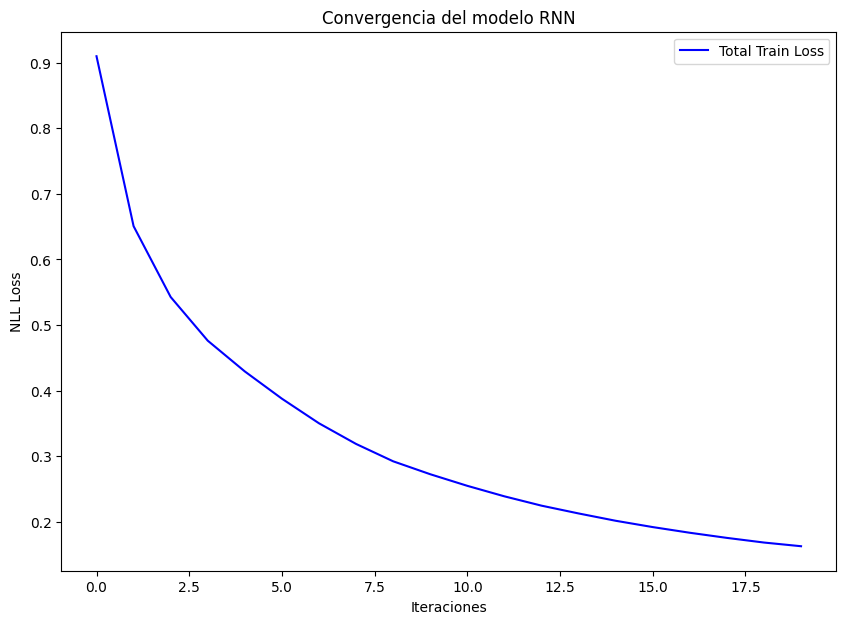

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(total_loss_train, "b", label="Total Train Loss")
#ax1.plot(loss_list_val, "g", label="Total Val Loss")
plt.title("Convergencia del modelo RNN", color="black")
ax1.set_xlabel("Iteraciones")

ax1.set_ylabel("NLL Loss", color="black")
ax1.legend(loc="upper right")
plt.show()

In [ ]:
# Save the model state dictionary to a file
torch.save(model.state_dict(), './Data/Model/gpt2summary.pth')

### Testing

In [ ]:
# Create an instance of your model (with the same architecture)
summ = GPT2LMHeadModel.from_pretrained('gpt2')

# Load the saved model state dictionary
summ.load_state_dict(torch.load('./Data/Model/gpt2summary.pth'))
summ.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
query = x_test.to_list()[0]
query

'bought year ago walmartand stopped carrying searching internet found amazon ordered box like spicy husband like orginal learning process sure thing figure many minute microwave great love'

In [ ]:
input_ids = tokenizer.encode(query, max_length=max_len_text, truncation=True, return_tensors="pt").to(device)

In [ ]:
input_ids

tensor([[   65,  2917,   614,  2084,  6514, 13822,   392,  5025,  6872, 10342,
          5230,  1043,   716,  5168,  6149,  3091,   588, 26880,  5229,   588,
          8745,  1292,  4673,  1429,  1654,  1517,  3785,   867,  5664, 27000,
          1049,  1842]], device='cuda:0')

In [ ]:
output_ids = summ.generate(input_ids, max_length=max_len_text, num_beams=5)
answer = tokenizer.decode(output_ids[0], skip_special_tokens=True, max_length=max_len_summary, pad_token_id=tokenizer.pad_token_id)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
answer

'bought year ago walmartand stopped carrying searching internet found amazon ordered box like spicy husband like orginal learning process sure thing figure many minute microwave great love'

In [ ]:
query = x_test.to_list()[1]
query

'taste really great smoothy add creamy texture bit nutty flavor great way add protein veggie diet love arrived fresh packed nicely ever run order seller'

In [ ]:
input_ids = tokenizer.encode(query, max_length=max_len_text, truncation=True, return_tensors="pt").to(device)

In [ ]:
input_ids

tensor([[   83,  4594,  1107,  1049,  7209,    88,   751, 27892, 11743,  1643,
          6701,   774,  9565,  1049,   835,   751,  7532,  1569, 23571,  5496,
          1842,  5284,  4713, 11856, 16576,  1683,  1057,  1502, 18583]],
       device='cuda:0')

In [ ]:
output_ids = summ.generate(input_ids, max_length=max_len_text, num_beams=5)
answer = tokenizer.decode(output_ids[0], skip_special_tokens=True, max_length=max_len_summary, pad_token_id=tokenizer.pad_token_id)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
answer

'taste really great smoothy add creamy texture bit nutty flavor great way add protein veggie diet love arrived fresh packed nicely ever run order seller'

![Colegio Bourbaki](./Images/Matematicas.png)

![Colegio Bourbaki](./Images/Contacto.png)